In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
from glob import glob
import PIL
from sklearn.metrics import confusion_matrix
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,Conv2D,MaxPool2D,BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import tensorflow as tf

In [41]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

GPU device not found
Found GPU at: 


In [42]:
metadata = pd.read_csv("/kaggle/input/skin-cancer-dataset/HAM10000_metadata.csv")

In [43]:

metadata.drop(['lesion_id','dx_type','age','sex','localization'],axis = 1,inplace = True)
metadata.head(5)

,image_id,dx
0,ISIC_0027419,bkl
1,ISIC_0025030,bkl
2,ISIC_0026769,bkl
3,ISIC_0025661,bkl
4,ISIC_0031633,bkl


In [44]:
metadata.dx.value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [45]:
le = LabelEncoder()
metadata['dx'] = le.fit_transform(metadata.dx)

In [46]:
df1 = metadata[metadata.dx==0]
df2 = metadata[metadata.dx==1]
df3 = metadata[metadata.dx==2]
df4 = metadata[metadata.dx==3]
df5 = metadata[metadata.dx==4]
df6 = metadata[metadata.dx==5]
df7 = metadata[metadata.dx==6]

In [47]:
samples = 200
df1_balanced = resample(df1,replace = True,n_samples = samples,random_state = 2)
df2_balanced = resample(df2,replace = True,n_samples = samples,random_state = 2)
df3_balanced = resample(df3,replace = True,n_samples = samples,random_state = 2)
df4_balanced = resample(df4,replace = True,n_samples = samples,random_state = 2)
df5_balanced = resample(df5,replace = True,n_samples = samples,random_state = 2)
df6_balanced = resample(df6,replace = True,n_samples = samples,random_state = 2)
df7_balanced = resample(df7,replace = True,n_samples = samples,random_state = 2)

In [48]:
merged = pd.concat([df1_balanced,df2_balanced,df3_balanced,
                  df4_balanced,df5_balanced,df6_balanced,df7_balanced])

In [49]:
dir = "/kaggle/input/skin-cancer-dataset/Skin Cancer/Skin Cancer"
id = [x.split('.')[0] for x in os.listdir(dir)]
image_path = {x:os.path.join(dir,f'{x}.jpg') for x in id}

In [50]:
metadata['path'] = metadata.image_id.map(image_path.get)

In [51]:
import PIL
from PIL import Image as img

In [52]:
metadata['image'] = metadata.path.map(lambda x:np.asarray(img.open(x).resize((80,80))))

In [53]:
metadata.drop(['image_id','path'],axis = 1,inplace = True)

In [54]:
metadata['image'] = metadata.image.apply(lambda x: x/255)

In [55]:
x = np.asarray(metadata['image'].tolist())
y = to_categorical(metadata['dx'],num_classes = 7)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.25,random_state = 4)

In [74]:
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.layers import GlobalAveragePooling2D, Dropout, Dense
from keras.models import Model, Sequential

# Define the input shape
input_shape = (80, 80, 3)

# Load the MobileNetV2 model without pre-trained weights
base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights=None)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = True

# Add a custom output layer for our specific task
num_classes = 7
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Combine the base model and the custom output layer
model = Model(inputs=base_model.input, outputs=predictions)

# Print the model summary
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 40, 40, 32)   864         input_12[0][0]                   
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 40, 40, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 40, 40, 32)   0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [75]:
model.compile(loss  = 'categorical_crossentropy', optimizer = 'Adam', metrics = 'acc')
batch_size = 16
epochs = 50
history = model.fit(x_train, y_train,epochs = epochs, batch_size= batch_size,
                   validation_data = (x_test,y_test), verbose = 2)
model.evaluate(x_test,y_test)

Epoch 1/50
470/470 - 127s - loss: 0.9963 - acc: 0.6648 - val_loss: 1.2209 - val_acc: 0.6641
Epoch 2/50
470/470 - 119s - loss: 0.8770 - acc: 0.6851 - val_loss: 1.1656 - val_acc: 0.6641
Epoch 3/50
470/470 - 120s - loss: 0.8281 - acc: 0.7030 - val_loss: 1.1746 - val_acc: 0.6641
Epoch 4/50
470/470 - 124s - loss: 0.7931 - acc: 0.7090 - val_loss: 1.1670 - val_acc: 0.6641
Epoch 5/50
470/470 - 120s - loss: 0.7799 - acc: 0.7191 - val_loss: 1.1611 - val_acc: 0.6641
Epoch 6/50
470/470 - 123s - loss: 0.7577 - acc: 0.7217 - val_loss: 1.2271 - val_acc: 0.6641
Epoch 7/50
470/470 - 130s - loss: 0.7234 - acc: 0.7375 - val_loss: 1.1840 - val_acc: 0.6641
Epoch 8/50
470/470 - 126s - loss: 0.7131 - acc: 0.7396 - val_loss: 1.2083 - val_acc: 0.6641
Epoch 9/50
470/470 - 118s - loss: 0.7185 - acc: 0.7412 - val_loss: 1.4077 - val_acc: 0.6641
Epoch 10/50
470/470 - 118s - loss: 0.6982 - acc: 0.7477 - val_loss: 1.3793 - val_acc: 0.5982
Epoch 11/50
470/470 - 118s - loss: 0.6755 - acc: 0.7552 - val_loss: 0.9754 - va

[2.392923355102539, 0.7040734887123108]

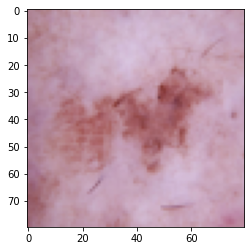

In [76]:
plt.imshow(x_test[0])

In [79]:
p = x_test[42].reshape([1,80,80,3])

In [80]:
print([round(x,3) for x in model.predict(p)[0]])
print(y_test[42])

[0.002, 0.697, 0.002, 0.0, 0.005, 0.293, 0.0]
[0. 1. 0. 0. 0. 0. 0.]
